In [1]:
import pandas as pd    # to load dataset
import numpy as np     # for mathematic equation
from nltk.corpus import stopwords   # to get collection of stopwords
from sklearn.model_selection import train_test_split       # for splitting dataset
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating
from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense # layers of the architecture
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model   # load saved model
import re

In [2]:
data = pd.read_csv('IMDB Dataset.csv')

print(data)

                                                  review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]


In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
english_stops = set(stopwords.words('english'))

## Load and Clean Dataset
In the original dataset, the reviews are still dirty. There are still html tags, numbers, uppercase, and punctuations. This will not be good for training, so in load_dataset() function, beside loading the dataset using pandas, I also pre-process the reviews by removing html tags, non alphabet (punctuations and numbers), stop words, and lower case all of the reviews.

**Encode Sentiments**
In the same function, I also encode the sentiments into integers (0 and 1). Where 0 is for negative sentiments and 1 is for positive sentiments.

In [6]:
def load_dataset():
    df = pd.read_csv('IMDB Dataset.csv')
    x_data = df['review']       # Reviews/Input
    y_data = df['sentiment']    # Sentiment/Output

    # PRE-PROCESS REVIEW
    x_data = x_data.replace({'<.*?>': ''}, regex = True)          # remove html tag
    x_data = x_data.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
    x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
    x_data = x_data.apply(lambda review: [w.lower() for w in review])   # lower case

    # ENCODE SENTIMENT -> 0 & 1
    y_data = y_data.replace('positive', 1)
    y_data = y_data.replace('negative', 0)

    return x_data, y_data

x_data, y_data = load_dataset()

print('Reviews')
print(x_data, '\n')
print('Sentiment')
print(y_data)

Reviews
0        [one, reviewers, mentioned, watching, oz, epis...
1        [a, wonderful, little, production, the, filmin...
2        [i, thought, wonderful, way, spend, time, hot,...
3        [basically, family, little, boy, jake, thinks,...
4        [petter, mattei, love, time, money, visually, ...
                               ...                        
49995    [i, thought, movie, right, good, job, it, crea...
49996    [bad, plot, bad, dialogue, bad, acting, idioti...
49997    [i, catholic, taught, parochial, elementary, s...
49998    [i, going, disagree, previous, comment, side, ...
49999    [no, one, expects, star, trek, movies, high, a...
Name: review, Length: 50000, dtype: object 

Sentiment
0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64


## Split Dataset
In this work, I decided to split the data into 80% of Training and 20% of Testing set using train_test_split method from Scikit-Learn. By using this method, it automatically shuffles the dataset. We need to shuffle the data because in the original dataset, the reviews and sentiments are in order, where they list positive reviews first and then negative reviews. By shuffling the data, it will be distributed equally in the model, so it will be more accurate for predictions.

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)

print('Train Set')
print(x_train, '\n')
print(x_test, '\n')
print('Test Set')
print(y_train, '\n')
print(y_test)

Train Set
14976    [movie, cruelty, world, i, found, liberating, ...
43391    [ugghhh, this, exactly, sort, pre, code, film,...
17199    [when, i, saw, film, festival, years, ago, i, ...
34746    [this, movie, utterly, hilarious, its, cast, c...
19896    [the, story, told, fluidly, there, interruptio...
                               ...                        
8494     [this, movie, truly, awful, after, seeing, adv...
45013    [a, delight, start, finish, if, like, muppets,...
16306    [i, bought, dvd, young, son, loves, toystory, ...
28255    [this, film, little, bad, it, even, kind, bad,...
43140    [watching, sequences, err, entire, film, devot...
Name: review, Length: 40000, dtype: object 

9614     [this, rip, roaring, western, watched, many, t...
15523    [mmm, big, stack, pancakes, sound, good, maple...
17870    [al, pacino, kim, basinger, tea, leoni, ryan, ...
33002    [the, first, one, best, the, second, one, suck...
42168    [i, absolutely, loved, movie, i, even, sure, p...
 

Function for getting the maximum review length, by calculating the mean of all the reviews length (using **numpy.mean**)

In [8]:
def get_max_length():
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

### Tokenize and Pad/Truncate Reviews
A Neural Network only accepts numeric data, so we need to encode the reviews. I use **tensorflow.keras.preprocessing.text.Tokenizer** to encode the reviews into integers, where each unique word is automatically indexed (using **fit_on_texts** method) based on x_train.
x_train and x_test is converted into integers using **texts_to_sequences** method.

Each reviews has a different length, so we need to add padding (by adding 0) or truncating the words to the same length (in this case, it is the mean of all reviews length) using tensorflow.keras.preprocessing.sequence.pad_sequences.
**bold text**

**post**, pad or truncate the words in the back of a sentence

**pre**, pad or truncate the words in front of a sentence

In [9]:
# ENCODE REVIEW
token = Tokenizer(lower=False)    # no need lower, because already lowered the data in load_data()
token.fit_on_texts(x_train)
x_train = token.texts_to_sequences(x_train)
x_test = token.texts_to_sequences(x_test)

max_length = get_max_length()

x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding

print('Encoded X Train\n', x_train, '\n')
print('Encoded X Test\n', x_test, '\n')
print('Maximum review length: ', max_length)

Encoded X Train
 [[    3  4736    86 ...     0     0     0]
 [45938     8   541 ...     2   244   831]
 [  172     1   118 ...     0     0     0]
 ...
 [    1  1098   168 ...     0     0     0]
 [    8     4    48 ...     0     0     0]
 [   65   745 13033 ...   628    20   400]] 

Encoded X Test
 [[    8  1501  9352 ...     0     0     0]
 [24386    99  6454 ...    61  5770     6]
 [ 1628  2763  2449 ...     0     0     0]
 ...
 [  479  1544  6384 ...     0     0     0]
 [   49    37    35 ... 19802 21284     3]
 [  902  7295   753 ...     0     0     0]] 

Maximum review length:  130


## Build Architecture/Model
**Embedding Layer:** in simple terms, it creates word vectors of each word in the word_index and group words that are related or have similar meaning by analyzing other words around them.

**LSTM Layer:** to make a decision to keep or throw away data by considering the current input, previous output, and previous memory. There are some important components in LSTM.

1. **Forget Gate**, decides information is to be kept or thrown away
2. **Input Gate**, updates cell state by passing previous output and current input into sigmoid activation function
3. **Cell State**, calculate new cell state, it is multiplied by forget vector (drop value if multiplied by a near 0), add it with the output from input gate to update the cell state value.
4. **Ouput Gate**, decides the next hidden state and used for predictions.

**Dense Layer:** compute the input with the weight matrix and bias (optional), and using an activation function. I use Sigmoid activation function for this work because the output is only 0 or 1.

The optimizer is **Adam** and the loss function is **Binary Crossentropy** because again the output is only 0 and 1, which is a binary number.

In [10]:
# ARCHITECTURE
EMBED_DIM = 32
LSTM_OUT = 64

model = Sequential()
model.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
model.add(LSTM(LSTM_OUT))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 130, 32)           2953280   
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2,978,177
Trainable params: 2,978,177
Non-trainable params: 0
_________________________________________________________________
None


## Training
For training, it is simple. We only need to fit our x_train (input) and y_train (output/label) data. For this training, I use a **mini-batch learning** method with a batch_size of 128 and 5 epochs.

Also, I added a **callback** called checkpoint to save the model locally for every epoch if its accuracy improved from the previous epoch.

In [11]:
checkpoint = ModelCheckpoint(
    'models/LSTM.h5',
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)

In [12]:
model.fit(x_train, y_train, batch_size = 128, epochs = 3, callbacks=[checkpoint])

Epoch 1/3
313/313 [==============================] - ETA: 0s - loss: 0.4942 - accuracy: 0.7283
Epoch 1: accuracy improved from -inf to 0.72830, saving model to models/LSTM.h5
313/313 [==============================] - 68s 186ms/step - loss: 0.4942 - accuracy: 0.7283
Epoch 2/3
313/313 [==============================] - ETA: 0s - loss: 0.2304 - accuracy: 0.9186
Epoch 2: accuracy improved from 0.72830 to 0.91855, saving model to models/LSTM.h5
313/313 [==============================] - 31s 98ms/step - loss: 0.2304 - accuracy: 0.9186
Epoch 3/3
313/313 [==============================] - ETA: 0s - loss: 0.1290 - accuracy: 0.9590
Epoch 3: accuracy improved from 0.91855 to 0.95903, saving model to models/LSTM.h5
313/313 [==============================] - 23s 75ms/step - loss: 0.1290 - accuracy: 0.9590


## Testing
To evaluate the model, we need to predict the sentiment using our x_test data and comparing the predictions with y_test (expected output) data. Then, we calculate the accuracy of the model by dividing numbers of correct prediction with the total data. Resulted an accuracy of **87.81%**

In [13]:
y_pred = model.predict(x_test, batch_size = 128)
y_pred = np.where(y_pred > 0.5,1,0)

true = 0
for i, y in enumerate(y_test):
    if y == y_pred[i]:
        true += 1

print('Correct Prediction: {}'.format(true))
print('Wrong Prediction: {}'.format(len(y_pred) - true))
print('Accuracy: {}'.format(true/len(y_pred)*100))

79/79 [==============================] - 1s 5ms/step
Correct Prediction: 8781
Wrong Prediction: 1219
Accuracy: 87.81



### Load Saved Model
Load saved model and use it to predict a movie review statement's sentiment (positive or negative).

In [14]:
loaded_model = load_model('models/LSTM.h5')

In [15]:
review = str(input('Movie Review: '))

Movie Review: That was an amazing movie. I liked it alot


In [16]:
#Pre-process input
regex = re.compile(r'[^a-zA-Z\s]')
review = regex.sub('', review)
print('Cleaned: ', review)

words = review.split(' ')
filtered = [w for w in words if w not in english_stops]
filtered = ' '.join(filtered)
filtered = [filtered.lower()]

print('Filtered: ', filtered)

Cleaned:  That was an amazing movie I liked it alot
Filtered:  ['that amazing movie i liked alot']


In [17]:
tokenize_words = token.texts_to_sequences(filtered)
tokenize_words = pad_sequences(tokenize_words, maxlen=max_length, padding='post', truncating='post')
print(tokenize_words)

[[ 143  395    3    1  343 8142    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]


In [18]:
result = loaded_model.predict(tokenize_words)
print(result)

1/1 [==============================] - 1s 782ms/step
[[0.97928476]]


In [19]:
if result >= 0.7:
    print('positive')
else:
    print('negative')

positive


## Machine Learning implementation



1.  Doing Preprocessing
2.  Converting into Vectors - TFIDF
3. train_test_split
4. Model Building



In [22]:
def load_dataset():
    df = pd.read_csv('IMDB Dataset.csv')
    x = df['review']       # Reviews/Input
    y = df['sentiment']    # Sentiment/Output

    # PRE-PROCESS REVIEW
    x = x.replace({'<.*?>': ''}, regex = True)          # remove html tag
    x = x.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
    x = x.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
    #x = x.apply(lambda review: [w.lower() for w in review])   # lower case
    x = x.apply(lambda review: ' '.join([w.lower() for w in review]))

    # ENCODE SENTIMENT -> 0 & 1
    y = y.replace('positive', 1)
    y = y.replace('negative', 0)

    return x, y

x, y = load_dataset()

print('Reviews')
print(x_data, '\n')
print('Sentiment')
print(y_data)

Reviews
0        [one, reviewers, mentioned, watching, oz, epis...
1        [a, wonderful, little, production, the, filmin...
2        [i, thought, wonderful, way, spend, time, hot,...
3        [basically, family, little, boy, jake, thinks,...
4        [petter, mattei, love, time, money, visually, ...
                               ...                        
49995    [i, thought, movie, right, good, job, it, crea...
49996    [bad, plot, bad, dialogue, bad, acting, idioti...
49997    [i, catholic, taught, parochial, elementary, s...
49998    [i, going, disagree, previous, comment, side, ...
49999    [no, one, expects, star, trek, movies, high, a...
Name: review, Length: 50000, dtype: object 

Sentiment
0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(max_features=5000)
X_tf = tf.fit_transform(x).toarray()

In [28]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_tf,y,test_size=0.2)

In [29]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train,y_train)

RandomForestClassifier()

In [33]:
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay
y_pred = model.predict(X_test)
accuracy_score(y_test,y_pred)

0.8477

In [35]:
cm = confusion_matrix(y_test,y_pred)

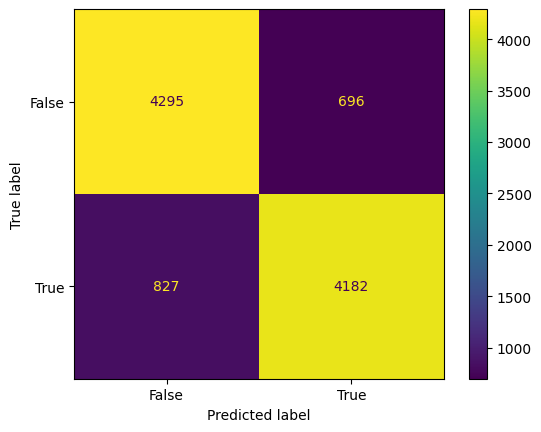

In [36]:
import matplotlib.pyplot as plt
cm_dis = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_dis.plot()
plt.show()